In [1]:
pip install Gpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.8 MB/s eta 0:00:00


Kernel Esponenziale:
MSE: 106156979.8509096
RMSE: 10303.25093603517
MAE: 7950.4452027522
R^2: 0.7502077399111962

Kernel Esponenziale Quadratico:
MSE: 435171449.4753905
RMSE: 20860.763396275564
MAE: 17161.984802652194
R^2: -0.0239784519420565

Coefficients model: [1.1385739]
Intercept model: -25401.83770736071
MSE: 49597678.759491935
RMSE: 7042.5619457333805
MAE: 5750.599775266366
R^2: 0.8832943788539234



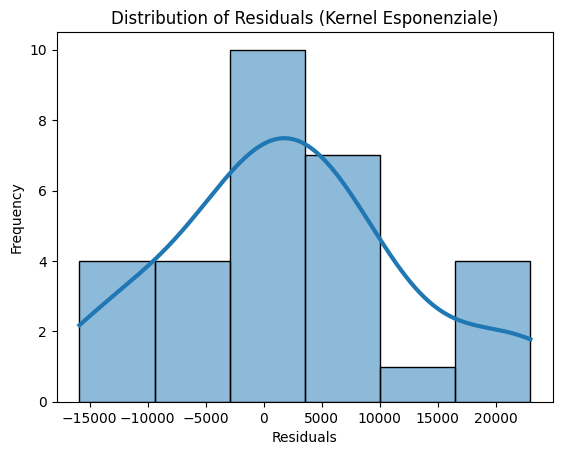

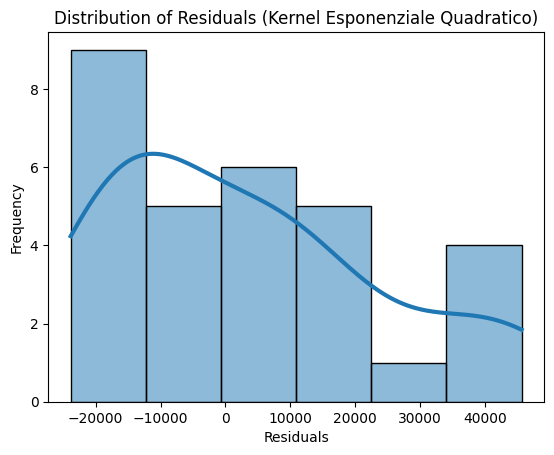

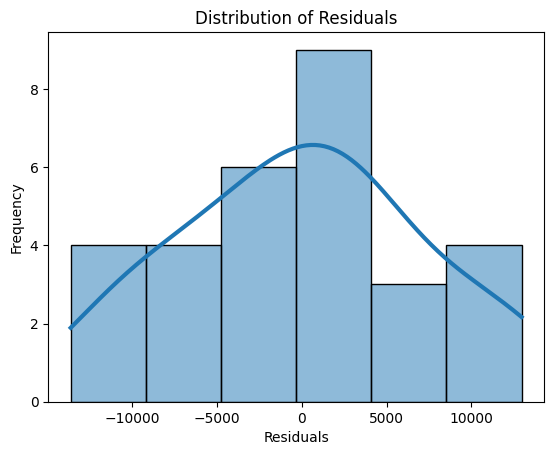

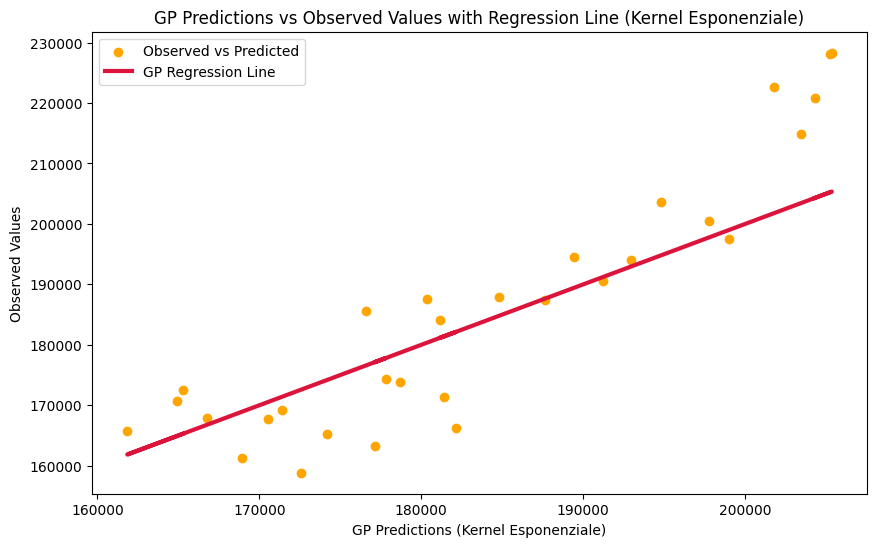

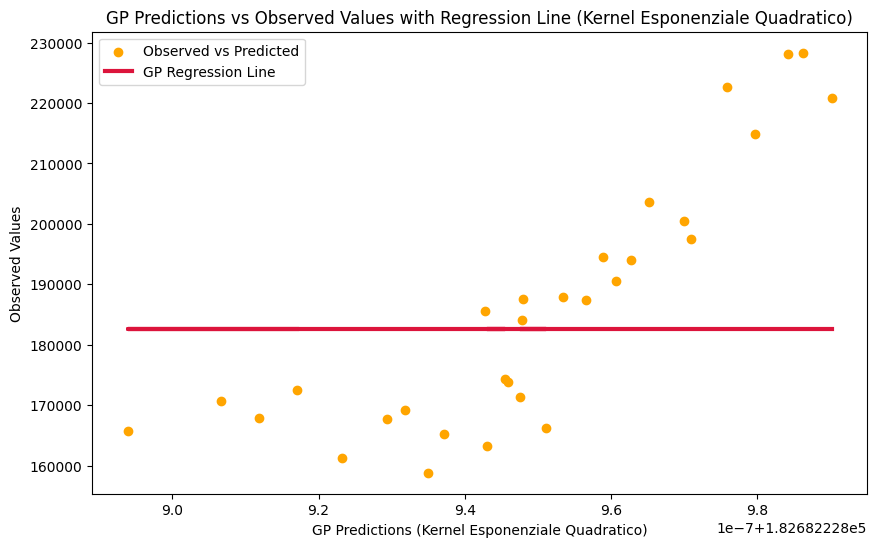

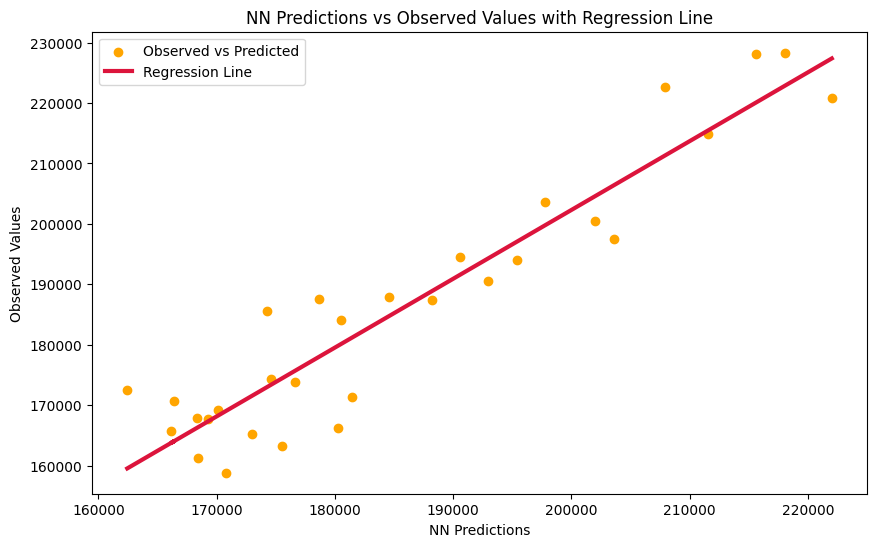

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def main():
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
    X = data[['Anthropogenic Forcing','CO2', 'CH4']].values
    y = data['Respiratory Diseases'].values
    plt.rcParams['lines.linewidth'] = 3

    # Normalizzazione dei dati
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test=X_scaled
    y_test=y

    # Caricamento del file CSV con le predizioni della rete neurale
    predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Resp-pre90-19.csv')
    y_pred_nn = predictions['Predicted Respiratory Diseases'].values.reshape(-1, 1)

    assert len(y_pred_nn) == len(X_test), "Le dimensioni delle predizioni e dei dati di test non corrispondono!"

    # Utilizzo del Processo Gaussiano con kernel esponenziale
    kernel_exp = GPy.kern.Exponential(input_dim=3, variance=1.0, lengthscale=1.0)
    kernel_exp.variance.unconstrain()
    kernel_exp.lengthscale.unconstrain()
    gp_model_exp = GPy.models.GPRegression(X_test, y_pred_nn, kernel_exp)
    gp_model_exp.optimize(messages=False)

    # Utilizzo del Processo Gaussiano con kernel esponenziale quadratico
    kernel_rbf = GPy.kern.RBF(input_dim=3, variance=1.0, lengthscale=1.0)
    kernel_rbf.variance.unconstrain()
    kernel_rbf.lengthscale.unconstrain()
    gp_model_rbf = GPy.models.GPRegression(X_test, y_pred_nn, kernel_rbf)
    gp_model_rbf.optimize(messages=False)

    #Utilizzo della regressione lineare sulle predizioni
    reg = LinearRegression()
    reg.fit(y_pred_nn.reshape(-1, 1), y_test)


   # Predizione con il modello GP con kernel esponenziale
    y_pred_gp_exp, _ = gp_model_exp.predict(X_test)
    mse_gp_exp = mean_squared_error(y_test, y_pred_gp_exp)
    rmse_gp_exp = np.sqrt(mse_gp_exp)
    mae_gp_exp = mean_absolute_error(y_test, y_pred_gp_exp)
    r2_gp_exp = r2_score(y_test, y_pred_gp_exp)

    print(f'Kernel Esponenziale:\n'
          f'MSE: {mse_gp_exp}\n'
          f'RMSE: {rmse_gp_exp}\n'
          f'MAE: {mae_gp_exp}\n'
          f'R^2: {r2_gp_exp}\n')

    # Predizione con il modello GP con kernel esponenziale quadratico
    y_pred_gp_rbf, _ = gp_model_rbf.predict(X_test)
    mse_gp_rbf = mean_squared_error(y_test, y_pred_gp_rbf)
    rmse_gp_rbf = np.sqrt(mse_gp_rbf)
    mae_gp_rbf = mean_absolute_error(y_test, y_pred_gp_rbf)
    r2_gp_rbf = r2_score(y_test, y_pred_gp_rbf)

    print(f'Kernel Esponenziale Quadratico:\n'
          f'MSE: {mse_gp_rbf}\n'
          f'RMSE: {rmse_gp_rbf}\n'
          f'MAE: {mae_gp_rbf}\n'
          f'R^2: {r2_gp_rbf}\n')

    # Valutazione del modello di regressione lineare
    y_pred_reg = reg.predict(y_pred_nn.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred_reg)
    mse_gp_rbf = mean_squared_error(y_test, y_pred_reg)
    rmse_gp_rbf = np.sqrt(mse_gp_rbf)
    mae_gp_rbf = mean_absolute_error(y_test, y_pred_reg)
    r2_gp_rbf = r2_score(y_test, y_pred_reg)

    print('Coefficients model:', reg.coef_)
    print('Intercept model:', reg.intercept_)
    print( f'MSE: {mse_gp_rbf}\n'
          f'RMSE: {rmse_gp_rbf}\n'
          f'MAE: {mae_gp_rbf}\n'
          f'R^2: {r2_gp_rbf}\n')

    # Analisi dei residui per il kernel esponenziale
    residuals_exp = y_test - y_pred_gp_exp.flatten()
    sns.histplot(residuals_exp, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals (Kernel Esponenziale)')
    plt.show()

    # Analisi dei residui per il kernel esponenziale quadratico
    residuals_rbf = y_test - y_pred_gp_rbf.flatten()
    sns.histplot(residuals_rbf, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals (Kernel Esponenziale Quadratico)')
    plt.show()

    # Analisi dei residui regressione Lineare
    residuals = y_test - y_pred_reg
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

    # Scatter plot delle predizioni del GP vs valori osservati per kernel esponenziale
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_gp_exp, y_test, label='Observed vs Predicted',color='orange')
    plt.plot(y_pred_gp_exp, y_pred_gp_exp, color='crimson', label='GP Regression Line')
    plt.xlabel('GP Predictions (Kernel Esponenziale)')
    plt.ylabel('Observed Values')
    plt.title('GP Predictions vs Observed Values with Regression Line (Kernel Esponenziale)')
    plt.legend()
    plt.show()

    # Scatter plot delle predizioni del GP vs valori osservati per kernel esponenziale quadratico
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_gp_rbf, y_test, label='Observed vs Predicted',color='orange')
    plt.plot(y_pred_gp_rbf, y_pred_gp_rbf, color='crimson', label='GP Regression Line')
    plt.xlabel('GP Predictions (Kernel Esponenziale Quadratico)')
    plt.ylabel('Observed Values')
    plt.title('GP Predictions vs Observed Values with Regression Line (Kernel Esponenziale Quadratico)')
    plt.legend()
    plt.show()


    # Scatter plot delle predizioni della rete neurale vs valori osservati
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_nn, y_test, label='Observed vs Predicted',color='orange')
    plt.plot(y_pred_nn, y_pred_reg, color='crimson', label='Regression Line')
    plt.xlabel('NN Predictions')
    plt.ylabel('Observed Values')
    plt.title('NN Predictions vs Observed Values with Regression Line')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()